In [1]:
%matplotlib inline

import numpy as np

from pytriqs.plot.mpl_interface import plt

In [2]:
plt.style.use('../../../doc/user_guide/notebook.mplstyle')

# Using the (semi) particle-hole transformation on the Hubbard model on a square lattice

## Hubbard model on a square lattice

The Hamiltonian of the Hubbard model on a square lattice is given by

$$
H=-t \sum_{\langle j, l\rangle \sigma}\left(c_{j \sigma}^{\dagger} c_{l \sigma}+c_{l \sigma}^{\dagger} c_{j \sigma}\right)+U \sum_{j} n_{j \uparrow} n_{j \downarrow}-\mu \sum_{j}\left(n_{j \uparrow}+n_{j \downarrow}\right)\,,
$$

here $c_{j\sigma}^{\dagger}$ creates an electron on site $j$ with spin $\sigma$ while $c_{j\sigma}$ destroys such an electron, further the operator $n_{j\sigma}$ count the number of electrons on site $j$ with spin $\sigma$.

The first term describes the kinetic energy of the electrons, which can be interpreted as an electron with spin $\sigma$ *hopping* from site $l$ to site $j$ and vice versa.
Here the angular braket under the sum means that we only take *hopping* terms between neighboring lattice sites into account and the energy that is gained by such a *hopping* process is given by $t$.
This is the most basic version of the kinetic part of the Hubbard model which can, and will be, extended later.

The second term describes the repulsive interaction between the electrons.
This repulsion is crudely approximated in the Hubbard model in the sense, that electrons only *see* each other if they occupy the same lattice site.
The energy that is needed to have a lattice site doubly occupied is given by $U$.

The last term describes the filling of the lattice via an energy offset by the chemical potential $\mu$.

The Hubbard model is therefore defined by the parameters $t$, $U$ and $\mu$, but we also need to know the temperature $T$ at which we shall observe the Hubbard model.
We will record these parameters using the `ParameterCollection` class in `triqs_tprf.ParameterCollection`.

In [4]:
from triqs_tprf.ParameterCollection import ParameterCollection

hubbard = ParameterCollection(   # -- Model Parameter
                                 norb=1, # Number of orbitals.
                                 t=1.0, # Hopping to nearest neighbor
                                 U=1.0, # Strength of the on-site interaction
                                 mu=0.0, # Chemical potential determining the filling.
                                 T=1000, # Temperature.
                                 spin=False, # Treat indices only for orbital character.
    
                                 # -- Model Parameter which will be used later
                                 tp=0.0, # Hopping to next-nearest neighbor
                                 zeeman=0.0, # Strength of zeeman term
    
                                 # -- Technical parameter
                                 nk=32, # Number of points in one dimension considered in the Brillouin zone.
                                 nw=50, # Number of Matsubara points in positive dimension.
                                        )
hubbard

T = 1000
U = 1.0
mu = 0.0
nk = 32
norb = 1
nw = 50
spin = False
t = 1.0
tp = 0.0
zeeman = 0.0

A representation of the kinetic part of the Hubbard model can be constructed using the `create_square_lattice` function in`triqs_tprf.tight_binding`.
This function needs information about the number of orbitals `norb` and the hopping energy `t`, so we can construct it with the parameters stored in `hubbard`. 
It returns a `TBLattice` object from which we can obtain the dispersion relation as a mesh over the Brillouin zone via its member function `on_mesh_brillouin_zone`.

The dispersion relation is stored in a `Gf` object and we can plot its bandstructure via the `bsplot` function in `plotting_tools`.

In [5]:
from triqs_tprf.tight_binding import create_square_lattice

H = create_square_lattice(norb=hubbard.norb, t=hubbard.t)

e_k = H.on_mesh_brillouin_zone(n_k=(hubbard.nk, hubbard.nk, 1))

Starting run with 1 MPI threads at : 2019-05-14 14:36:57.601312


In [6]:
path = [(r'$\Gamma$', np.array([0.0, 0.0, 0.0])), 
        ('X', np.array([0.5, 0.0, 0.0])),
        ('M', np.array([0.5, 0.5, 0.0])), 
        (r'$\Gamma$', np.array([0.0, 0.0, 0.0])), 
       ]

Text(0.5,0,'DOS')

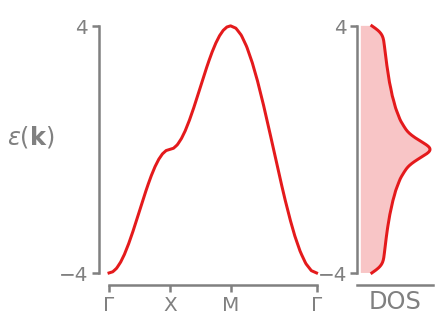

In [8]:
from matplotlib import gridspec
from triqs_tprf.plotting_tools import bsplot, dosplot

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
gs.update(wspace=0.2, hspace=0.05)

# -- Bandstructure
ax_bs = plt.subplot(gs[0])
ax_bs.bsplot(e_k[0,0], path)
ax_bs.set_ylabel('$\epsilon(\mathbf{k})$', rotation=0, ha='right')

# -- Density of states
ax_dos = plt.subplot(gs[1])
ax_dos.dosplot(e_k[0,0])
ax_dos.set_xlabel('DOS')

## Charge- and spin-susceptibility

To get physical information about the Hubbard model we will calculate the spin and charge susceptibilites in the random phase approximation (RPA) limit to see at which parameters they diverge and a phase transition occurs.

To use the RPA we need the non-interaction particle-hole bubble which is contstructed via the non-interaction Green's function.
We therefore first construct a Matsubara frequency mesh object by using `MeshImFreq` from `pytriqs.gf`.
This constructor needs to know the inverse temperature `beta` in $1/\mathrm{eV}$, which we can get from the temperature in $\mathrm{Kelvin}$ by using the converter function `temperature_to_beta` from `triqs_tprf.utilities`, the statistic of our particle `S`, in our case a Fermion, and the number of points to use `n_max` in one dimension.
With this mesh object and the dispersion relation `e_k` we can then use `lattice_dyson_g0_wk` from `triqs_tprf.lattice` to construct the non-interaction Green's function for a specific filling given by `mu`.
The non-interaction particle-hole bubble is then constructed from this `Gf` object by using `imtime_bubble_chi0_wk` from `triqs_tprf.lattice_utils`.

We wraped all of this in the function `get_chi0` which uses a `ParameterCollection` as an input to get all the parameters.

In [9]:
from pytriqs.gf import MeshImFreq
from triqs_tprf.lattice import lattice_dyson_g0_wk
from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk
from triqs_tprf.utilities import temperature_to_beta

def get_chi0(p, e_k=None):
    """Return the non-interaction susceptibility for model parameters in a ParameterCollection
    """
    if not e_k:
        H = create_square_lattice(**p)
        e_k = H.on_mesh_brillouin_zone(n_k=(p.nk, p.nk, 1))

    wmesh = MeshImFreq(beta=temperature_to_beta(p.T), S='Fermion', n_max=p.nw)
    g0_wk = lattice_dyson_g0_wk(mu=p.mu, e_k=e_k, mesh=wmesh)
    
    chi0_wk = imtime_bubble_chi0_wk(g0_wk, nw=p.nw)
        
    return chi0_wk

chi0_wk = get_chi0(hubbard, e_k)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 11.6045250062
nk    = 1024
nw    = 100
norb  = 1

Approx. Memory Utilization: 0.01 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_tr_from_grt_PH (bubble in tau & r)
--> chi_wr_from_chi_tr
--> chi_wk_from_chi_wr (r->k)


We can now calculate the spin and charge susceptibiliy in the RPA limit with the known equations.

$$
\chi^{(\mathrm{c})}=\frac{\chi^{(0)}}{1+\chi^{(0)} U}
\quad
\mathrm{and}
\quad
\chi^{(\mathrm{s})}=\frac{\chi^{(0)}}{1-\chi^{(0)} U}\,.
$$

These kind of equation is implemented as `solve_rpa_PH` in `triqs_tprf.lattice` and we wrapped it in the function `get_chiRPA` to immediately obtain the charge- and spin-susceptibilites in RPA from given parameters.
We can plot them for $\nu=0$, using the `Idx` object from `from pytriqs.gf`, in the same fashion as the bandstructure.
There we can see, that the spin-susceptibiliy has a peak at the M-point, which will lead to an antiferromagnetic (AFM) state for large enough $U$.

In [10]:
from triqs_tprf.lattice import solve_rpa_PH

def get_chiRPA(p, chi0_wk=None):
    """Return the charge- and spin-susceptibility in the RPA limit for model parameters in a ParameterCollection
    """
    
    if not chi0_wk:
        chi0_wk = get_chi0(p)
    
    U = p.U * np.ones(shape=(1,1,1,1), dtype=complex)

    chi_c_wk = solve_rpa_PH(chi0_wk, -U) # Minus for correct charge rpa equation
    chi_s_wk = solve_rpa_PH(chi0_wk, U)
    
    return chi_c_wk, chi_s_wk

chi_c_wk, chi_s_wk = get_chiRPA(hubbard, chi0_wk)

Text(0.55,0.18,'$\\chi^{(c)}$')

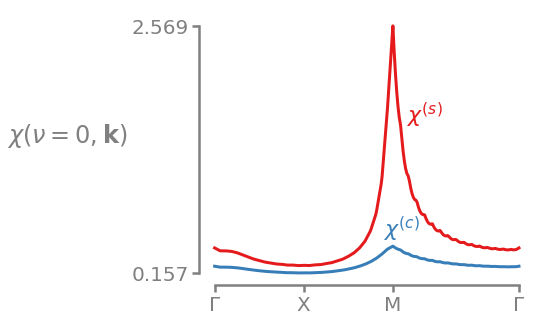

In [11]:
from pytriqs.gf import Idx

ax_bs = plt.subplot(111)

ax_bs.bsplot(chi_s_wk[Idx(0), :], path)
ax_bs.bsplot(chi_c_wk[Idx(0), :], path)

ax_bs.set_ylabel(r'$\chi(\nu=0, \mathbf{k})$', rotation=0, ha='right')
ax_bs.text(0.62, 0.6, "$\chi^{(s)}$", transform = ax_bs.transAxes, size=22, color='C0')
ax_bs.text(0.55, 0.18, "$\chi^{(c)}$", transform = ax_bs.transAxes, size=22, color='C1')

We will now introduce a small function `get_spin_phase_transistion` that will find $U_\mathrm{c}$, the interaction strength at which the Hubbard model goes into a spin ordered phase.
This is done by searching for the $U$ at which 

$$
\frac{1}{\chi^{(s)}} \approx 0\,,
$$

via [`scipy.optimize.brentq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html#scipy.optimize.brentq).

In [12]:
from scipy.optimize import brentq

def get_spin_phase_transistion(p):
    """Return U at which model p transitions to spin order via root search
    """    
    chi0_wk = get_chi0(p)
    
    def one_over_spin(U):

        _, chi_s_wk = get_chiRPA(p.alter(U=U), chi0_wk)
        
        # -- If any value is below zero we are already in an ordered phase
        if np.any(chi_s_wk.data[np.abs(chi_s_wk.data) > 1e-3] < 0.0 ):
            return -1
        
        chi_at_critical_k = np.max(chi_s_wk.data)
        return 1./chi_at_critical_k
    
    U_c = brentq(one_over_spin, 0.0, 10.0)
    
    return U_c

To scan through some parameters we will alter our base model `hubbard`, which parameters are stored as a `ParameterCollection`, and only change the specific parameters.
We do this with the function `parameter_scan` which outputs us a `ParameterCollections` objects which is a container for multiple `ParameterCollection`.
We can then loop over the `ParameterCollections` object to access the individual `ParameterCollection` objects.

To show this off we will do a crude scan of a $T-U$ phase diagram to map out the AFM phase.

In [13]:
%%capture

from triqs_tprf.ParameterCollection import parameter_scan

Ts = [1000, 750, 500, 250]
# --  Use the hubbard model as a template for the parameters and only change T
hubbard_models = parameter_scan(hubbard, T=Ts)

U_cs = []

for hubbard_model in hubbard_models:
    
    U_c = get_spin_phase_transistion(hubbard_model)   
    U_cs.append(U_c)

Text(0.625,0.3,'AFM')

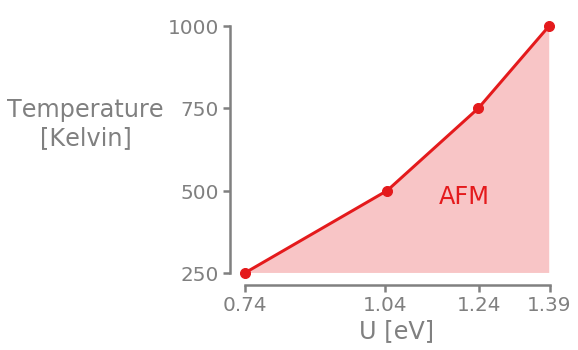

In [14]:
ax_pd = plt.subplot()

ax_pd.plot(U_cs, Ts, "o", ls="-")
ax_pd.fill_between(U_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25)

ax_pd.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd.set_xlabel('U [eV]')

ax_pd.set_yticks(Ts)
ax_pd.set_xticks([np.round(ele,2) for ele in U_cs])

ax_pd.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd.spines['bottom'].set_bounds(ax_pd.get_xticks()[0], ax_pd.get_xticks()[-1])

ax_pd.text(0.625, 0.3, "AFM", transform = ax_pd.transAxes, size=24, color='C0')

## Particle-Hole Symmetry

The Hubbard model with only nearest neighbor hopping inhibts a useful particle-hole symmetry.
To introduce this, let us first introduce the notation of a bipartite lattice.
A bipartite lattice can be subdivided into two sublattices for which every lattice site on one of them only has neighboring sites from the other sublattice.
This is the case for our square lattice.

Let us now introduce a new kind of creation and annihilation operator

$$
d_{l \sigma}=(-1)^{l} c^\dagger_{l \sigma}\,,\quad
\mathrm{and}\quad
d_{l \sigma}^{\dagger}=(-1)^{l} c_{l \sigma}\,.\\
$$

Here $l$ is either $0$ for one sublattice and $1$ for the other.

Using this substitution is called particle-hole transformation (PHT), because the analog of the number operator for these new ones counts the number of holes, i.e.

$$
\tilde{n}_{l \sigma} = d_{l \sigma}^{\dagger} d_{l \sigma}= \underbrace{(-1)^{2l}}_{=1} c_{l \sigma}c_{l \sigma}^{\dagger} = 1-c_{l \sigma}^{\dagger} c_{l \sigma}=
1-n_{l \sigma}\,.
$$

Let us now inspect how the Hubbard Hamiltonian changes under such a PHT.
The kinetic part consists for only nearest neighbor hopping of terms of the form $c_{1 \sigma}^{\dagger} c_{j \sigma}$, where $l$ and $j$ are always from a different sublattice.
Using the PHT on it yields

$$
c_{l \sigma}^{\dagger} c_{j \sigma} \xrightarrow{\mathrm{PHT}} \underbrace{(-1)^{j+l}}_{=-1} d_{l \sigma} d_{j \sigma}^{\dagger}=
-d_{l \sigma} d_{j \sigma}^{\dagger}= d_{l \sigma}^{\dagger} d_{j \sigma}\,,
$$

showing that the kinetic part is invariant.

The interaction has terms of the form $n_{j \uparrow} n_{j \downarrow}$, using the PHT here yields

$$
n_{j \uparrow} n_{j \downarrow} =  c_{j \uparrow}^{\dagger} c_{j \uparrow} c_{j \downarrow}^{\dagger} c_{j \downarrow}
\xrightarrow{\mathrm{PHT}}
(-1)^{4j} d_{j \uparrow} d_{j \uparrow}^{\dagger} d_{j \downarrow} d_{j \downarrow}^{\dagger}=
(1- d_{j \uparrow}^{\dagger}d_{j \uparrow}) (1-d_{j \downarrow}^{\dagger}d_{j \downarrow})=\\ 
(1 - \tilde{n}_{j \uparrow}) (1 -\tilde{n}_{j \downarrow})=
1 - \tilde{n}_{j \uparrow} - \tilde{n}_{j \downarrow} + \tilde{n}_{j \uparrow}\tilde{n}_{j \downarrow}\,,
$$

which leads to additional terms.
But those terms only consist of a shift in chemical potential and an constant energy.
We can therfore write a new Hamiltonian for the Hubbard model which is also invariant in the interaction term for a PHT

$$
H=-t \sum_{\langle j, l\rangle \sigma}\left(c_{j \sigma}^{\dagger} c_{l \sigma}+c_{l \sigma}^{\dagger} c_{j \sigma}\right)+U \sum_{j}\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right)-\mu \sum_{j}\left(n_{j \uparrow}+n_{j \downarrow}\right)\,,
$$

we will cal this the particle-hole symmetric form of the Hubbard model.

Doing the PHT on its interaction term yields

$$
\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right) \xrightarrow{\mathrm{PHT}}
\left(1-\tilde{n}_{j \uparrow}-\frac{1}{2}\right)\left(1-\tilde{n}_{j \downarrow}-\frac{1}{2}\right) = 
\left(-\tilde{n}_{j \uparrow}+\frac{1}{2}\right)\left(-\tilde{n}_{j \downarrow}+\frac{1}{2}\right)=\\
(-1)^2 \left(\tilde{n}_{j \uparrow}-\frac{1}{2}\right)\left(\tilde{n}_{j \downarrow}-\frac{1}{2}\right)=
\left(\tilde{n}_{j \uparrow}-\frac{1}{2}\right)\left(\tilde{n}_{j \downarrow}-\frac{1}{2}\right)
$$

showing the invariance.

Using the PHT on the chemical potential term yields

$$
n_{j \uparrow}+n_{j \downarrow} \xrightarrow{\mathrm{PHT}} (1-\tilde{n}_{j \uparrow}) + (1-\tilde{n}_{j \downarrow}) = 2 - (\tilde{n}_{j \uparrow} + \tilde{n}_{j \downarrow})\,,
$$

and therefore an unimportant constant term, but also a sign change.

The particle-hole symmetric form of the Hubbard model can therefore be mapped via a PHT to an identical Hubbard model with only a negative chemical potential.

To use this knowledge let us now see how the spin operator in $z$-direction changes under a PHT

$$
S^z_j = n_{j \uparrow} - n_{j \downarrow} \xrightarrow{\mathrm{PHT}} (1 - \tilde{n}_{j \uparrow}) - (1 - \tilde{n}_{j \downarrow}) = \tilde{n}_{j \downarrow} - \tilde{n}_{j \uparrow} = \tilde{S}^z_j\,.
$$

This sign change for the direction of the spin is unimportant for the calculation of susceptibilites and therefore the spin susceptibility is invariant under PHT

$$
\langle S^z_jS^z_j \rangle = \langle \tilde{S}^z_j\tilde{S}^z_j \rangle\,.
$$

The spin susceptibility calculated at a Hubbard model with some chemical potential $\mu$ is therefore the same as for a Hubbard model with chemical potential $-\mu$.
We test this by calculating the phase transition to the AFM for a few chemical potential

In [15]:
%%capture

mus = [-.5, -.25, -0.1, 0.1, .25, .5]

hubbard_models = parameter_scan(hubbard, mu=mus)

U_cs = []

for hubbard_model in hubbard_models:
        
    U_c = get_spin_phase_transistion(hubbard_model)   
    U_cs.append(U_c)

Text(0.125,0.3,'AFM')

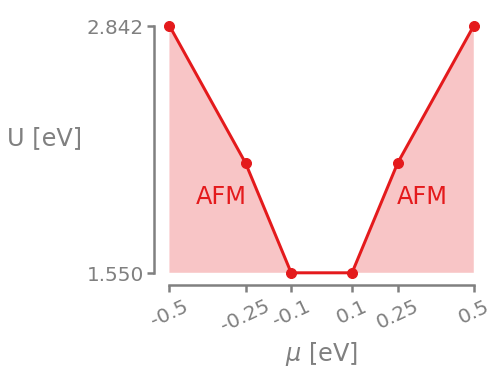

In [16]:
ax_pd = plt.subplot(111)

ax_pd.plot(mus, U_cs, "o", ls="-")
ax_pd.fill_between(mus,[min(U_cs)]*len(U_cs),U_cs, alpha=0.25)

ax_pd.set_ylabel('U [eV]', rotation=0, ha='right')
ax_pd.set_xlabel('$\mu$ [eV]')

ax_pd.set_yticks([min(U_cs), max(U_cs)])
ax_pd.set_xticks(mus)
ax_pd.set_xticklabels(mus, rotation=25)

ax_pd.spines['left'].set_bounds(min(U_cs), max(U_cs))
ax_pd.spines['bottom'].set_bounds(min(mus), max(mus))

ax_pd.text(0.725, 0.3, "AFM", transform = ax_pd.transAxes, size=24, color='C0')
ax_pd.text(0.125, 0.3, "AFM", transform = ax_pd.transAxes, size=24, color='C0')

Here we see that the AFM phase is indeed symmetric for $\mu=0$.

If we now introduce next-nearest neighbor hopping we introduce hopping between sublattices of the same type.
The kinetic term of the Hubbard model does then contain terms of the form $c_{1 \sigma}^{\dagger} c_{l \sigma}$, which are not invariant under PHT

$$
c_{l \sigma}^{\dagger} c_{l \sigma} \longrightarrow \underbrace{(-1)^{2l}}_{=1} d_{l \sigma} d_{l \sigma}^{\dagger}=
d_{l \sigma} d_{l \sigma}^{\dagger}= -d_{l \sigma}^{\dagger} d_{l \sigma}\,.
$$

Such a model is therefore not symmetric in its AFM phase for $\mu=0$, which we can test.

We alter our `ParameterCollection` `hubbard` where we have stored the parameters of our Hubbard model and give this new one the additional parameter `tp`.
This parameter stands for the energy gain of next-nearest neighbor hopping processes.
The `SquareLattice` class knows about this parameter and we can proceed as before to obatin the dispersion relation.
Plotting it, we already see, that the density of states is no longer symmetric.
We preceed as before and obtain a $\mu-U$ phase diagram.
There we can observe that the symmetry is destroyed.

In [17]:
hubbard_next_nearest_neighbor_hopping = hubbard.alter(tp=-0.05)

H = create_square_lattice(**hubbard_next_nearest_neighbor_hopping)

e_k_nn = H.on_mesh_brillouin_zone(n_k=(hubbard_next_nearest_neighbor_hopping.nk,
                                    hubbard_next_nearest_neighbor_hopping.nk, 1))

Text(0.5,0,'DOS')

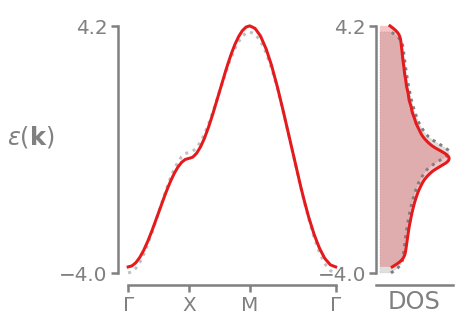

In [18]:
# -- Bandstructure
ax_bs = plt.subplot(gs[0])
ax_bs.bsplot(e_k[0,0], path, color='grey', ls="dotted", alpha=0.5)
ax_bs.bsplot(e_k_nn[0,0], path)
ax_bs.set_ylabel('$\epsilon(\mathbf{k})$', rotation=0, ha='right')

# -- Density of states
ax_dos = plt.subplot(gs[1])
ax_dos.dosplot(e_k[0,0], color='grey', linestyle='dotted')
ax_dos.dosplot(e_k_nn[0,0])
ax_dos.set_xlabel('DOS')

In [19]:
%%capture

mus = [-.5, -.25, -0.1, 0.1, .25, .5]

hubbard_models = parameter_scan(hubbard_next_nearest_neighbor_hopping, mu=mus)

U_cs = []

for hubbard_model in hubbard_models:
        
    U_c = get_spin_phase_transistion(hubbard_model)   
    U_cs.append(U_c)

Text(0.08,0.1,'AFM')

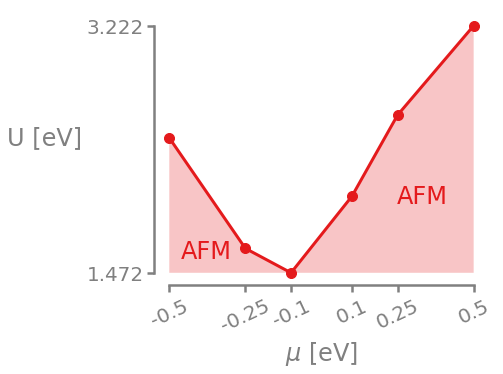

In [20]:
ax_pd = plt.subplot(111)

ax_pd.plot(mus, U_cs, "o", ls="-")
ax_pd.fill_between(mus,[min(U_cs)]*len(U_cs),U_cs, alpha=0.25)

ax_pd.set_ylabel('U [eV]', rotation=0, ha='right')
ax_pd.set_xlabel('$\mu$ [eV]')

ax_pd.set_yticks([min(U_cs), max(U_cs)])
ax_pd.set_xticks(mus)
ax_pd.set_xticklabels(mus, rotation=25)

ax_pd.spines['left'].set_bounds(min(U_cs), max(U_cs))
ax_pd.spines['bottom'].set_bounds(min(mus), max(mus))

ax_pd.text(0.725, 0.3, "AFM", transform = ax_pd.transAxes, size=24, color='C0')
ax_pd.text(0.08, 0.1, "AFM", transform = ax_pd.transAxes, size=24, color='C0')

## Semi particle-hole transformation

If we use the PHT only on one spin specices it is called a semi particle-hole transformation (SPHT).
This means

$$
c_{j \uparrow}^{\dagger} \xrightarrow{\mathrm{SPHT}} d_{j \uparrow}^{\dagger}\quad\mathrm{and}\quad
c_{j \uparrow} \xrightarrow{\mathrm{SPHT}} d_{j \uparrow}\\
c_{j \downarrow}^{\dagger} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \downarrow}\quad\mathrm{and}\quad
c_{j \downarrow} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \downarrow}^{\dagger}\,.
$$

Lets remember the particle-hole symmetric Hubbard model that is invariant under a PHT

$$
H=-t \sum_{\langle j, l\rangle \sigma}\left(c_{j \sigma}^{\dagger} c_{l \sigma}+c_{l \sigma}^{\dagger} c_{j \sigma}\right)+U \sum_{j}\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right)-\mu \sum_{j}\left(n_{j \uparrow}+n_{j \downarrow}\right)\,.
$$

The kinetic term only consist of operators with the same spin and is therefore invariant under SPHT as it was under PHT.
The interaction term on the underhand has to be treated with more care

$$
\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right) \xrightarrow{\mathrm{SPHT}}
\left(\tilde{n}_{j \uparrow}-\frac{1}{2}\right)\left(1-\tilde{n}_{j \downarrow}-\frac{1}{2}\right) = 
\left(\tilde{n}_{j \uparrow} - \frac{1}{2}\right)\left(\frac{1}{2}-\tilde{n}_{j \downarrow}\right) = \\
-\left(\tilde{n}_{j \uparrow} - \frac{1}{2}\right)\left(\tilde{n}_{j \downarrow}-\frac{1}{2}\right)\,.
$$

Under a SPHT we map the repulsive Hubbard model with $U$ to the attractive one with $-U$.
The chemical potential term is also not invariant under a SPHT

$$
n_{j \uparrow}+n_{j \downarrow} \xrightarrow{\mathrm{SPHT}}
\tilde{n}_{j \uparrow}+1-\tilde{n}_{j \downarrow} = 
1 + \left(\tilde{n}_{j \uparrow}-\tilde{n}_{j \downarrow}\right)\,,
$$

and transforms into a Zeeman term.

To summarize the SPHT maps the Hubbard Hamiltonian with interaction strength $U$ and chemical potential $\mu$ to a Hubbard Hamiltonian with interaction strength $-U$, a chemical potential of $0$ and an additional Zeeman term of strength $\mu$.

Lets start again with the spin operator in $z$-direction,

$$
S^z_j = n_{j \uparrow} - n_{j \downarrow} \xrightarrow{\mathrm{SPHT}} \tilde{n}_{j \uparrow} - (1 - \tilde{n}_{j \downarrow}) = -1 + \tilde{n}_{j \uparrow} + \tilde{n}_{j \downarrow}\,.
$$

which is just the density operator 

$$
\tilde{n}_{j}= \tilde{n}_{j \uparrow} + \tilde{n}_{j \downarrow}
$$

with a constant.
If one calculates a susceptibility one is only interested in the change of the expectation value of an obserable $A$ when going from an unperturbed system to one which is perturbed by a field coupling to operator $B$.
Therefore a constant factor in an observable is unimportant when calculating susceptibilites.

If we consider a Hubbard model at half-filling, i.e. $\mu=0.0$ the $T-U$, this means, that the spin-susceptibility in the repulsive Hubbard model is equal to the charge-suscpeitbility in the attractive one.
We already see this in the RPA equations for the susceptibilites were they only differ by a sign, but we will test it anyways.
To study the transition to a charge density wave we will the function `get_charge_phase_transistion`, were we scan for divergences is the range of negative $U$.

In [21]:
def get_charge_phase_transistion(p):
    """Return U at which model p transitions to charge order via root search
    """
    chi0_wk = get_chi0(p)
    
    def one_over_charge(U):

        chi_c_wk, _ = get_chiRPA(p.alter(U=U), chi0_wk)
        
        # -- If any value is below zero we are already in an ordered phase
        if np.any(chi_c_wk.data[np.abs(chi_c_wk.data) > 1e-3] < 0.0 ):
            return -1
        
        chi_at_critical_k = np.max(chi_c_wk.data)
        return 1./chi_at_critical_k
    
    U_c = brentq(one_over_charge, -10, 0.0)
    
    return U_c

In [22]:
%%capture

Ts = [1000, 750, 500, 250]
hubbard_models = parameter_scan(hubbard, T=Ts)

U_spin_cs = []
U_charge_cs = []

for hubbard_model in hubbard_models:
    
    U_spin_c = get_spin_phase_transistion(hubbard_model)
    U_charge_c = get_charge_phase_transistion(hubbard_model)   

    U_spin_cs.append(U_spin_c)
    U_charge_cs.append(U_charge_c)

Text(0.07,0.15,'CDW')

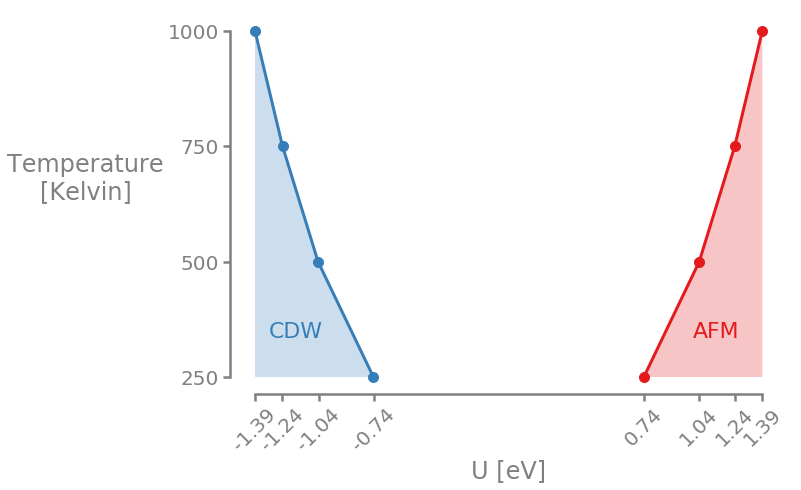

In [23]:
fig = plt.figure(figsize=(10,7))

ax_pd = plt.subplot(111)

ax_pd.plot(U_spin_cs, Ts, "o", ls="-")
ax_pd.fill_between(U_spin_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25)

ax_pd.plot(U_charge_cs, Ts, "o", ls="-")
ax_pd.fill_between(U_charge_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25)

ax_pd.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd.set_xlabel('U [eV]')

ax_pd.set_yticks(Ts)
ax_pd.set_xticks([np.round(ele,2) for ele in U_spin_cs+U_charge_cs])
ax_pd.set_xticklabels([np.round(ele,2) for ele in U_spin_cs+U_charge_cs], rotation=45)

ax_pd.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd.spines['bottom'].set_bounds(min(ax_pd.get_xticks()), max(ax_pd.get_xticks()))

ax_pd.text(0.83, 0.15, "AFM", transform = ax_pd.transAxes, size=22, color='C0')
ax_pd.text(0.07, 0.15, "CDW", transform = ax_pd.transAxes, size=22, color='C1')

As we can see the two phases are perfectly symmetric for $U=0$.

The SPHT also gives information about the superconducting phase of the attractive Hubbard model, this can be seen by transforming the ladder operators of the spin

$$
S^+_j = S^x_j + iS^y_j = c_{j \uparrow}^{\dagger}c_{j \downarrow} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \uparrow}^{\dagger}d_{j \downarrow}^{\dagger} = \tilde{\Delta}^{\dagger}\,,\\
S^-_j = S^x_j - iS^y_j = c_{j \downarrow}^{\dagger}c_{j \uparrow} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \downarrow}d_{j \uparrow} = \tilde{\Delta}\,.
$$

The x- and y-components of the spin operator are transformed to the complex superconducting oder parameter with a phase factor.
We wil focus on $S^x$, because even if we apply a Zeeman term the x- and y-components will be degenerate.
This means, that if we find a diverging $\langle S^xS^x \rangle$ in the repulsive model at some $U$, giving us AFM inplane order, we will see a homogeneous superconducting phase at $-U$.

To calculate $\langle S^xS^x \rangle$ we need the spin dependent general susceptibility tensor.
We can obtain this from $\chi^{(c)}$ and $\chi^{(s)}$ if our system is $\mathrm{SU(2)}$ symmetric.
This can be done via the `general_susceptibility_from_charge_and_spin` function from `triqs_tprf.rpa_tensor`.

In [24]:
from triqs_tprf.rpa_tensor import general_susceptibility_from_charge_and_spin

chi_c_wk, chi_s_wk  = get_chiRPA(hubbard)

chi_rpa_general_wk = general_susceptibility_from_charge_and_spin(chi_c_wk, chi_s_wk)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 11.6045250062
nk    = 1024
nw    = 100
norb  = 1

Approx. Memory Utilization: 0.01 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_tr_from_grt_PH (bubble in tau & r)
--> chi_wr_from_chi_tr
--> chi_wk_from_chi_wr (r->k)


We can then use the matrix representation of $S^x$ to do the contraction with `chi_rpa_general_wk` to obtain $\langle S^xS^x \rangle$.
This can be done via the function `chi_contraction` in `triqs_tprf.lattice_utils`.

In [25]:
from triqs_tprf.lattice_utils import chi_contraction

S_x = 0.5 * np.array([[0,1], [1,0]])

chi_sxsx = chi_contraction(chi_rpa_general_wk, S_x, S_x)

But for a $\mathrm{SU(2)}$ symmetric system doing this is unnecessary, because

$$
\langle S^z S^z \rangle = \langle S^x S^x \rangle\,,
$$

and we therefore already know where the superconducting phase in the attractive model lies, it is degenerate with the CDW.

### Linearized Eliashberg equation

We will now use the implementation of the linearized Eliashberg equation to confirm this superconducting phase.
To do this we need to construct the particle-particle vertex $\Gamma(\omega, \mathbf{k})$ which in the case of the attractive Hubbard model is just a constant 

$$
\Gamma(\omega, \mathbf{k}) = -U\,.
$$

We can then use the `solve_eliashberg` function of the `triqs_tprf.eliashberg` module to solve the linearized eliashberg equation for the specifc $\Gamma$ to obtain the $\lambda$ as an indicator for the strength of the superconducting phase.
If

$$
\lambda = 1
$$

we encounter a phase transition to the superconducting phase.
To find this phase transition we use the same procedure as for the susceptibilites and search when

$$
\lambda - 1 \approx 0\,.
$$

In [26]:
from pytriqs.gf import Gf, MeshProduct
from triqs_tprf.eliashberg import solve_eliashberg

def get_lambda_delta(p, g0_wk=None):
    """Solve the linearized eliashberg equation for model parameters in a ParameterCollection
    """
    if not g0_wk:
        H = create_square_lattice(**p)
        e_k = H.on_mesh_brillouin_zone(n_k=(p.nk, p.nk, 1))

        wmesh = MeshImFreq(beta=temperature_to_beta(p.T), S='Fermion', n_max=p.nw)
        g0_wk = lattice_dyson_g0_wk(mu=p.mu, e_k=e_k, mesh=wmesh)
    
    # -- Make particle-particle vertex that is constant is frequency and momentum space
    wmesh_boson = MeshImFreq(beta=temperature_to_beta(p.T), S='Boson', n_max=p.nw)
    gamma_pp = Gf(mesh=MeshProduct(wmesh_boson, g0_wk.mesh[1]),
                  target_shape=g0_wk.target_shape*2)
    gamma_pp.data[:] = p.U
    
    Es, eigen_modes = solve_eliashberg(gamma_pp, g0_wk, solver='IRAM', tol=1e-5)

    return Es[0], eigen_modes[0]

def get_sc_phase_transistion(p, guess=None):
    """Return U at which model p transitions to superconducting order via root search
    """
    H = create_square_lattice(**p)
    e_k = H.on_mesh_brillouin_zone(n_k=(p.nk, p.nk, 1))

    wmesh = MeshImFreq(beta=temperature_to_beta(p.T), S='Fermion', n_max=p.nw)
    g0_wk = lattice_dyson_g0_wk(mu=p.mu, e_k=e_k, mesh=wmesh)
        
    def lambda_minus_1(U):
        lamb, _ = get_lambda_delta(p.alter(U=U), g0_wk)        
        return lamb - 1.0
    
    upper = 1.1*guess
    lower = 0.9*guess
    
    U_c = brentq(lambda_minus_1, lower, upper)

    return U_c

In [27]:
Ts = [1000, 750, 500, 250]
hubbard_models = parameter_scan(hubbard, T=Ts)
guesses = [-ele for ele in U_spin_cs]

U_sc_cs = []

for hubbard_model, guess in zip(hubbard_models, guesses):
    
    U_sc_c = get_sc_phase_transistion(hubbard_model, guess)

    U_sc_cs.append(U_sc_c)

Text(0.07,0.15,'SC')

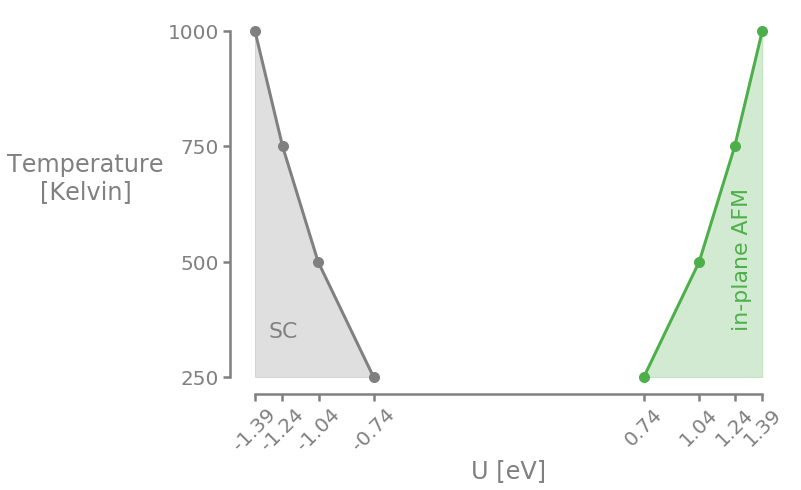

In [28]:
fig = plt.figure(figsize=(10,7))

ax_pd = plt.subplot(111)

ax_pd.plot(U_spin_cs, Ts, "o", ls="-", color='C2')
ax_pd.fill_between(U_spin_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25, color='C2')

ax_pd.plot(U_sc_cs, Ts, "o", ls="-", color='grey')
ax_pd.fill_between(U_sc_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25, color='grey')

ax_pd.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd.set_xlabel('U [eV]')

ax_pd.set_yticks(Ts)
ax_pd.set_xticks([np.round(ele,2) for ele in U_spin_cs+U_sc_cs])
ax_pd.set_xticklabels([np.round(ele,2) for ele in U_spin_cs+U_sc_cs], rotation=45)

ax_pd.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd.spines['bottom'].set_bounds(min(ax_pd.get_xticks()), max(ax_pd.get_xticks()))

ax_pd.text(0.9, 0.5, "in-plane AFM", transform = ax_pd.transAxes, size=22, color='C2', rotation=90)
ax_pd.text(0.07, 0.15, "SC", transform = ax_pd.transAxes, size=22, color='grey')

## Not at half-filling

If we are not at half-filling in the repulsive Hubbard model we have to take the Zeeman term into account in the attractive model.
Because the implementation of the linearized Eliashberg equation is right now limited to $\mathrm{SU(2)}$ symmetric systems and the Zeeman term breaks this symmetry we will apply the Zeeman term in the repulsive model.
This means, that 

$$
\langle S^z S^z \rangle \neq \langle S^x S^x \rangle\,,
$$

and the CDW will therefore no longer be degenerate with the superconducting phase.

The Zeeman term is already included in the `SquareLattice` class, but to use it we have to input a Hubbard model that carries spin explicitly.
We therefore create the `hubbard_spin_dependent` variable which is a copy of `hubbard` but with `spin=True`.

In [29]:
hubbard_spin_dependent = hubbard.alter(spin=True)

H = create_square_lattice(**hubbard_spin_dependent.alter(zeeman=1.0))
e_k = H.on_mesh_brillouin_zone(n_k=(hubbard_spin_dependent.nk, hubbard_spin_dependent.nk, 1))

Text(0.52,0.6,'$|\\downarrow \\rangle$')

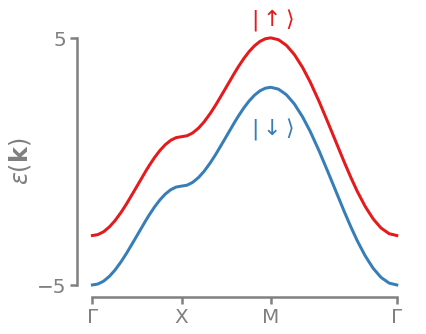

In [30]:
# -- Bandstructure
ax_bs = plt.subplot(111)

ax_bs.bsplot(e_k[0,0], path)
ax_bs.bsplot(e_k[1,1], path)

ax_bs.set_ylabel('$\epsilon(\mathbf{k})$')

ax_bs.text(0.52, 1., r"$|\uparrow \rangle$", transform = ax_bs.transAxes, size=22, color='C0')
ax_bs.text(0.52, 0.6, r"$|\downarrow \rangle$", transform = ax_bs.transAxes, size=22, color='C1')

We also define `get_chiRPA_spin_dependent` that outputs the spin-dependent general RPA-susceptibility from which we can build any kind of particle-hole susceptibility for two operators.
The function `get_phase_transition` can then find ....

In [31]:
from triqs_tprf.rpa_tensor import kanamori_quartic_tensor

def get_chiRPA_spin_dependent(p, chi0_wk=None):
    
    if not chi0_wk:
        chi0_wk = get_chi0(p)
        
    U_abcd = kanamori_quartic_tensor(p.norb, p.U, 0, 0, 0) # Two time norb to take spin int account
        
    chi_rpa_wk = solve_rpa_PH(chi0_wk, U_abcd)
    
    return chi_rpa_wk

def get_phase_transition(p, op1, op2, lower=0.0, upper=10):
    """Return U at which model p transitions to any order of op1 and op2 via root search
    """
    chi0_wk = get_chi0(p)
    
    def one_over_chi(U):
        
        chi_rpa_wk = get_chiRPA_spin_dependent(p.alter(U=U), chi0_wk=chi0_wk)
        chi = chi_contraction(chi_rpa_wk, op1, op2)
        
        # -- If any value is below zero we are already in an ordered phase
        if np.any(chi.data[np.abs(chi.data) > 1e-3] < 0.0 ):
            return -1
        
        chi_at_critical_k = np.max(chi.data)
        
        return 1./chi_at_critical_k
    
    U_c = brentq(one_over_chi, lower, upper)
    
    return U_c

We can then scan the phase space of the repulsive Hubbard model with a Zeeman term of strength $\xi$ and an attractive model which is doped by $\mu=\xi$.
And as we know the in-plane AFM, defined by $\langle S_z S_z \rangle$, is symmetric to the CDW, defined by $\langle nn \rangle$, for $U=0$.
The same is true for the out-of-plane AFM, defined by $\langle S_x S_x \rangle$, and the superconducting phase, defined by $\langle \Delta \Delta^\dagger \rangle$.

The calculated phase doagram confirms this.

In [32]:
%%capture

# Density operator
n = np.eye(2)
# Spin operator
S_z = 0.5 * np.array([[1,0], [0,-1]])

xi = 0.1

Ts = [1000, 750, 500]
hubbard_models_doped = parameter_scan(hubbard_spin_dependent.alter(mu=xi), T=Ts)
hubbard_models_zeeman = parameter_scan(hubbard_spin_dependent.alter(zeeman=xi), T=Ts)

U_spin_cs = []
U_charge_cs = []
U_sx_cs = []
U_sc_cs = []

for hubbard_model_doped, hubbard_model_zeeman in zip(hubbard_models_doped, hubbard_models_zeeman):
    
    U_spin_c = get_phase_transition(hubbard_model_zeeman, S_z, S_z, 0, 10)
    U_charge_c = get_phase_transition(hubbard_model_doped, n, n, -10, 0)
    U_sx_c = get_phase_transition(hubbard_model_zeeman, S_x, S_x)
    U_sc_c = get_sc_phase_transistion(hubbard_model_doped.alter(spin=False), guess=-U_sx_c)   

    U_spin_cs.append(U_spin_c)
    U_charge_cs.append(U_charge_c)
    U_sx_cs.append(U_sx_c)
    U_sc_cs.append(U_sc_c)

Text(0.5,1,'Hubbard with $\\mathrm{Zeeman}=\\xi$')

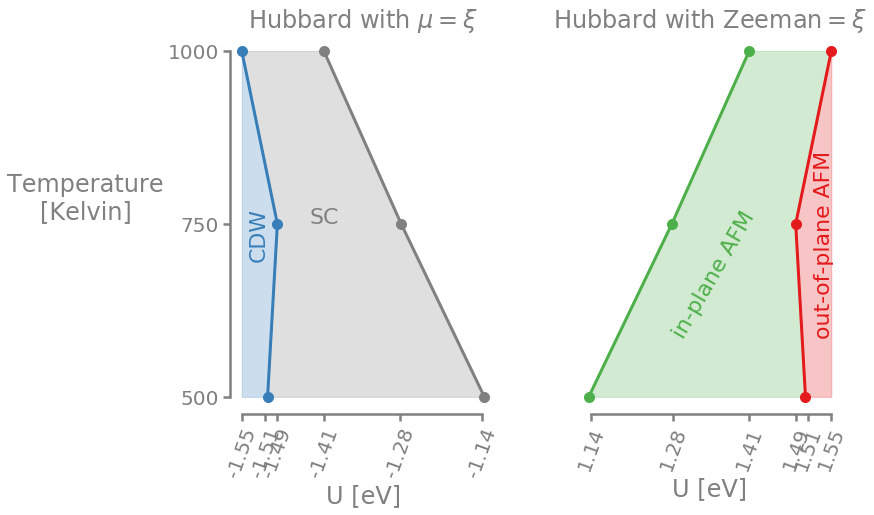

In [38]:
fig = plt.figure(figsize=(11,7))

ax_pd_right = plt.subplot(122)

ax_pd_right.plot(U_sx_cs, Ts, "o", ls="-", color='C2')
ax_pd_right.fill_betweenx(Ts, U_sx_cs, U_spin_cs , alpha=0.25, color='C2')

ax_pd_right.plot(U_spin_cs, Ts, "o", ls="-", color='C0')
ax_pd_right.fill_betweenx(Ts, U_spin_cs, [max(U_spin_cs)]*len(U_spin_cs) , alpha=0.25, color='C0')

ax_pd_left = plt.subplot(121)

ax_pd_left.plot(U_sc_cs, Ts, "o", ls="-", color='grey')
ax_pd_left.fill_betweenx(Ts, U_sc_cs, U_charge_cs, alpha=0.25, color='grey')

ax_pd_left.plot(U_charge_cs, Ts, "o", ls="-", color='C1')
ax_pd_left.fill_betweenx(Ts, U_charge_cs, [min(U_charge_cs)]*len(U_charge_cs), alpha=0.25, color='C1')

ax_pd_left.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd_left.set_xlabel('U [eV]')
ax_pd_right.set_xlabel('U [eV]')

ax_pd_left.set_yticks(Ts)
ax_pd_right.set_yticks([])

ax_pd_left.set_xticks([np.round(ele,2) for ele in U_sc_cs + U_charge_cs])
ax_pd_left.set_xticklabels([np.round(ele,2) for ele in U_sc_cs + U_charge_cs], rotation=70)
ax_pd_right.set_xticks([np.round(ele,2) for ele in U_sx_cs + U_spin_cs])
ax_pd_right.set_xticklabels([np.round(ele,2) for ele in U_sx_cs + U_spin_cs], rotation=70)

ax_pd_left.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd_right.spines['left'].set_visible(False)

ax_pd_left.spines['bottom'].set_bounds(min(ax_pd_left.get_xticks()), max(ax_pd_left.get_xticks()))
ax_pd_right.spines['bottom'].set_bounds(min(ax_pd_right.get_xticks()), max(ax_pd_right.get_xticks()))


ax_pd_left.text(0.3, 0.5, "SC", transform = ax_pd_left.transAxes, size=22, color='grey')
ax_pd_left.text(0.07, 0.5, "CDW", transform = ax_pd_left.transAxes, size=22, color='C1', rotation=90)

ax_pd_right.text(0.35, 0.5, "in-plane AFM", transform = ax_pd_right.transAxes, size=22, color='C2', rotation=60)
ax_pd_right.text(0.89, 0.65, "out-of-plane AFM", transform = ax_pd_right.transAxes, size=22, color='C0', rotation=90)

ax_pd_left.set_title(r'Hubbard with $\mu=\xi$', color='grey', size=24)
ax_pd_right.set_title(r'Hubbard with $\mathrm{Zeeman}=\xi$', color='Grey', size=24)

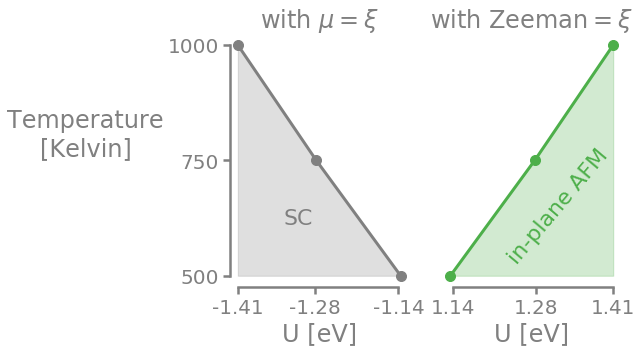

In [69]:
fig = plt.figure(figsize=(9,5))

ax_pd_right = plt.subplot(122)

ax_pd_right.plot(U_sx_cs, Ts, "o", ls="-", color='C2')
ax_pd_right.fill_betweenx(Ts, U_sx_cs, np.max(U_sx_cs) , alpha=0.25, color='C2')

ax_pd_left = plt.subplot(121)

ax_pd_left.plot(U_sc_cs, Ts, "o", ls="-", color='grey')
ax_pd_left.fill_betweenx(Ts, U_sc_cs, np.min(U_sc_cs), alpha=0.25, color='grey')

ax_pd_left.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd_left.set_xlabel('U [eV]')
ax_pd_right.set_xlabel('U [eV]')

ax_pd_left.set_yticks(Ts)
ax_pd_right.set_yticks([])

ax_pd_left.set_xticks([np.round(ele,2) for ele in U_sc_cs])
ax_pd_left.set_xticklabels([np.round(ele,2) for ele in U_sc_cs])
ax_pd_right.set_xticks([np.round(ele,2) for ele in U_sx_cs])
ax_pd_right.set_xticklabels([np.round(ele,2) for ele in U_sx_cs])

ax_pd_left.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd_right.spines['left'].set_visible(False)

ax_pd_left.spines['bottom'].set_bounds(min(ax_pd_left.get_xticks()), max(ax_pd_left.get_xticks()))
ax_pd_right.spines['bottom'].set_bounds(min(ax_pd_right.get_xticks()), max(ax_pd_right.get_xticks()))


ax_pd_left.text(0.3, 0.25, "SC", transform = ax_pd_left.transAxes, size=22, color='grey')

ax_pd_right.text(0.35, 0.5, "in-plane AFM", transform = ax_pd_right.transAxes, size=22, color='C2', rotation=50)

ax_pd_left.set_title(r'with $\mu=\xi$', color='grey', size=24)
ax_pd_right.set_title(r'with $\mathrm{Zeeman}=\xi$', color='Grey', size=24)

fig.tight_layout()

plt.savefig('test2.svg')

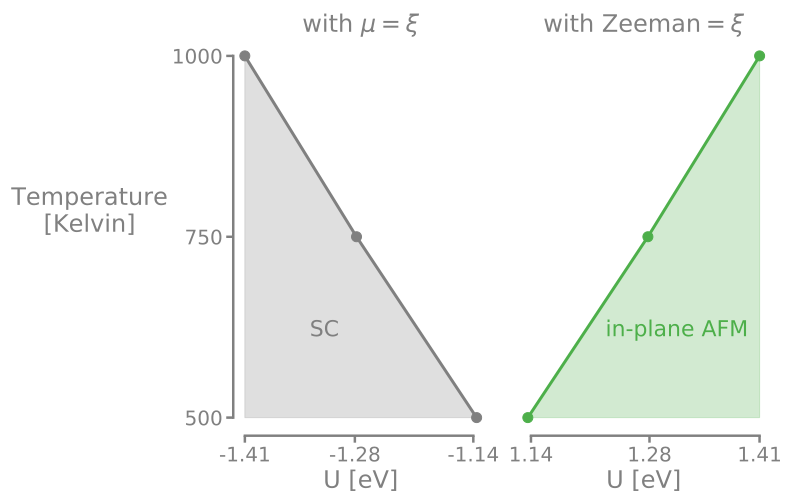

In [60]:
from IPython.core.display import SVG
SVG(filename='test.svg')

We can also check the gap function of the superconducting phase and study its symmetry in momentum space.
There we can see, that it is constant......

In [34]:
_, delta_1 = get_lambda_delta(hubbard.alter(mu=xi, U=U_sc_cs[0]))

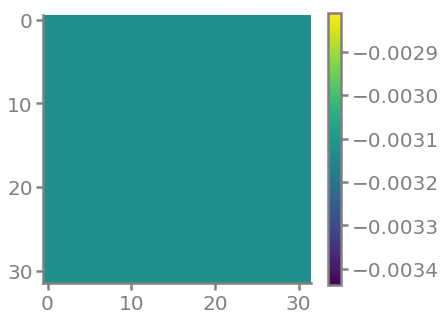

In [35]:
delta_plot = delta_1[Idx(0), : ].data.reshape(hubbard.nk, hubbard.nk).real

plt.imshow(delta_plot, vmin=0.9*np.mean(delta_plot), vmax=1.1*np.mean(delta_plot))
plt.colorbar()